In [131]:
import re
import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from itertools import chain
from collections import Counter

from reviews.config import root_dir

data_dir = root_dir / "data"
out_dir = root_dir / "output"
processed_data_dir = data_dir / "processed"
asum_output_dir = root_dir / "output" / "asum"

sns.set_style("white")

primary_color = "#ECE81A"  # 108de4ff"
secondary_color = "#C3C5C5"

# Models Comparison

In [132]:
total_df = pd.DataFrame()
for n_topics in [10, 20, 30, 50]:
    for model in ["asum", "jst"]:
        for norm in ["raw", "stemming", "lemmatization"]:
            filename = out_dir / model / f"metrics_{model}_{n_topics}_text_{norm}.csv"

            if not filename.exists():
                continue

            df = pd.read_csv(filename)
            df["model"] = model
            df["normalization"] = norm

            total_df = pd.concat((df, total_df))

In [133]:
total_df[total_df["model"] == "asum"].groupby(["normalization", "n_topics"])[
    ["f1_macro", "f1_weighted", "f1_micro"]
].mean()

f1_macro  f1_weighted  f1_micro
normalization n_topics                                 
lemmatization 10        0.610995     0.822938  0.783224
              20        0.609943     0.825730  0.787974
              30        0.609353     0.826766  0.789831
              50        0.619306     0.832808  0.797833
raw           10        0.603015     0.819242  0.778656
              20        0.604509     0.824062  0.786347
              30        0.604621     0.825871  0.789284
              50        0.614762     0.835591  0.803572
stemming      10        0.626172     0.836788  0.803171
              20        0.619642     0.831365  0.795388
              30        0.619473     0.834202  0.800157
              50        0.632539     0.844270  0.814507

In [134]:
total_df[total_df["model"] == "jst"].groupby(["normalization", "n_topics"])[
    ["f1_macro", "f1_weighted", "f1_micro"]
].mean()

f1_macro  f1_weighted  f1_micro
normalization n_topics                                 
stemming      10        0.563276     0.764685  0.702036
              20        0.557473     0.757249  0.692407
              30        0.558806     0.757243  0.692017
              50        0.559091     0.761021  0.697063

(0.55, 0.65)

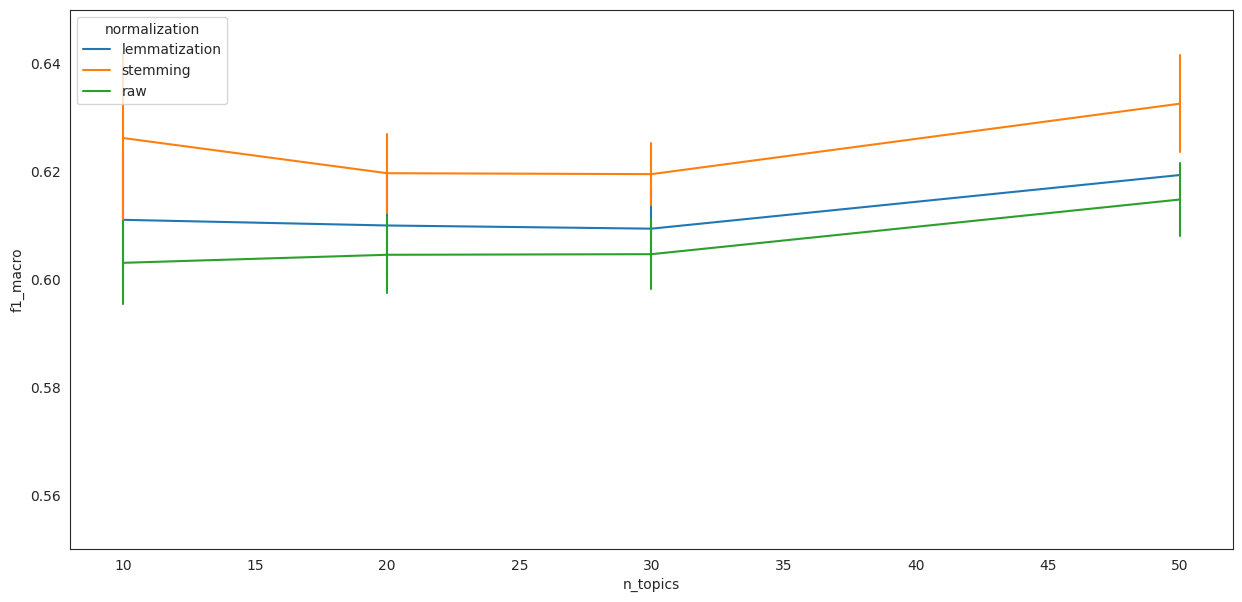

In [135]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(
    total_df[total_df["model"] == "asum"],
    y="f1_macro",
    x="n_topics",
    hue="normalization",
    ax=ax,
    err_style="bars",
    errorbar="sd",
)
ax.set_ylim([0.55, 0.65])

(0.5, 0.65)

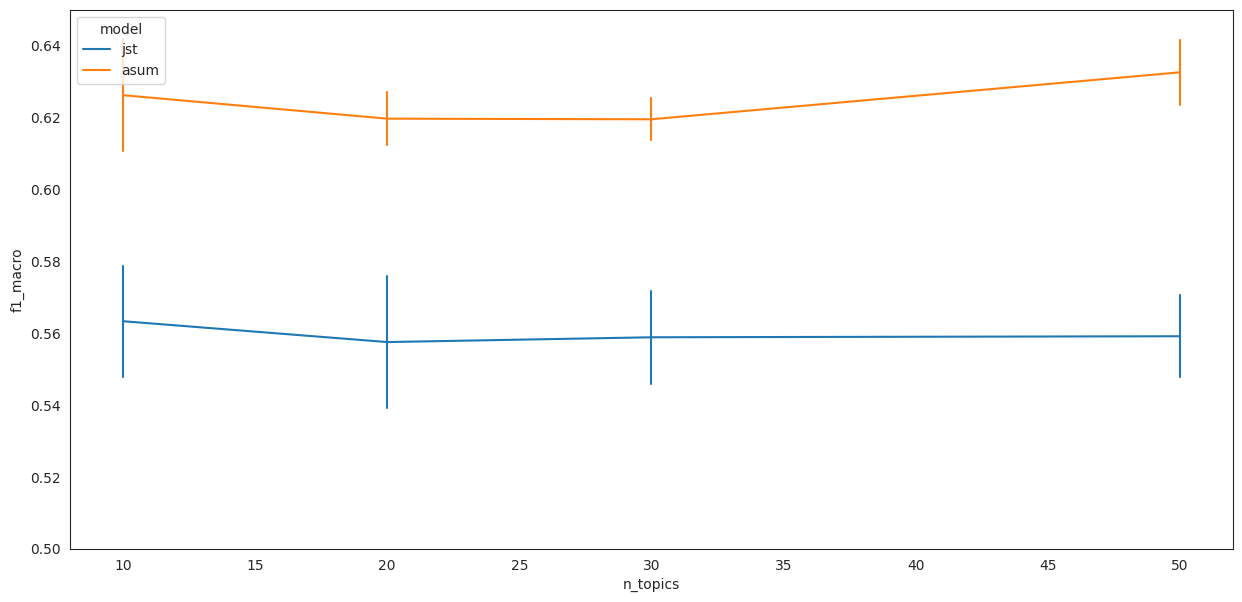

In [136]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(
    total_df[total_df["normalization"] == "stemming"],
    y="f1_macro",
    x="n_topics",
    hue="model",
    ax=ax,
    err_style="bars",
    errorbar="sd",
)
ax.set_ylim([0.5, 0.65])

## Split by Commas and Conjunctions

In [137]:
total_df = pd.DataFrame()
n_topics = 50
model = "asum"
norm = "stemming"
for extra in ["", "_conj", "_comma"]:
    filename = out_dir / model / f"metrics_{model}_{n_topics}_text_{norm}{extra}.csv"

    if not filename.exists():
        continue

    df = pd.read_csv(filename)
    df["extra"] = "stemming" if extra == "" else extra.replace("_", "")

    total_df = pd.concat((df, total_df))
total_df

,Unnamed: 0,run,n_topics,f1_macro,f1_weighted,f1_micro,extra
0,0,0,50,0.609326,0.828343,0.792396,conj
1,1,1,50,0.620142,0.833890,0.799475,conj
2,2,2,50,0.604614,0.825127,0.787982,conj
3,3,3,50,0.622586,0.835038,0.800898,conj
4,4,4,50,0.614391,0.835558,0.803525,conj
5,5,5,50,0.603964,0.827490,0.792068,conj
6,6,6,50,0.614266,0.828762,0.792104,conj
7,7,7,50,0.614358,0.834184,0.801189,conj
8,8,8,50,0.624325,0.839479,0.808049,conj
9,9,9,50,0.618075,0.834241,0.800496,conj


<AxesSubplot: xlabel='f1_macro', ylabel='extra'>

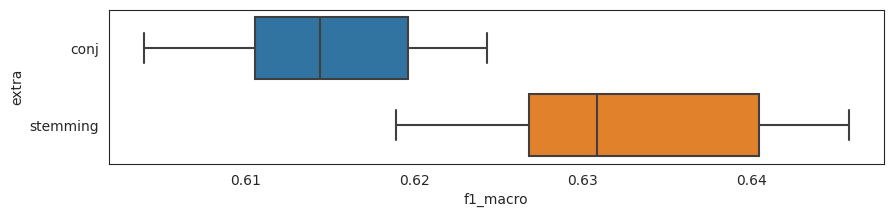

In [138]:
fig, ax = plt.subplots(figsize=(10, 2))
sns.boxplot(total_df, y="extra", x="f1_macro", ax=ax)

In [139]:
total_df.groupby("extra")[["f1_macro", "f1_weighted"]].mean()

,f1_macro,f1_weighted
extra,,
conj,0.614605,0.832211
stemming,0.632539,0.844270


# ASPECT BASED SENTIMENT ANALYSIS (ASUM)

In [140]:
NORM = "stemming"  # stemming, lemmatization
FIELD = "text"  # text, text+summary
EXTRA = ""  # _conj

In [141]:
n_runs = 10
n_topics = 50
iterations = 1000

alpha = 0.1  # 50 / n_topics # 0.1
beta = [0.001, 0.1, 0]
gamma = [1, 1]

# Read Reviews Data

In [142]:
# load tokens
reviews_df = pd.read_json(processed_data_dir / f"reviews_{FIELD}_{NORM}{EXTRA}.json.gz")

too_long = reviews_df["tokens"].apply(
    lambda x: any([len(sent) > 50 for sent in x])
)  # len(list(chain.from_iterable(x))) > 50
empty = reviews_df["tokens"].apply(lambda x: len(list(chain.from_iterable(x))) == 0)

print(f"Too Long Reviews: {too_long.sum() / len(reviews_df) * 100:.2f}%")
print(f"Empty Reviews: {empty.sum() / len(reviews_df) * 100:.2f}%")

reviews_df["tokens"] = reviews_df["tokens"].apply(
    lambda x: [sent for sent in x if len(sent) <= 50]
)

Too Long Reviews: 0.54%
Empty Reviews: 0.05%


In [143]:
filename_prefix = f"STO2-T{n_topics}-S2(2)-A{alpha}-B{','.join([f'{float(x)}' for x in beta])}-G{','.join([f'{float(x):.1f}' for x in gamma])}-I{iterations}"

## PI = documents x sentiment

In [144]:
pi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Pi.csv", header=None)

## PHI = vocabulary x senti aspects

In [145]:
phi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Phi.csv")
phi_df.sort_values(by="S1-T1", ascending=False, inplace=True)

## THETA = documents x senti aspects


In [146]:
def map_topic_sentiment(column_name):
    if "Unnamed" in column_name:
        return None

    values = column_name.split("-")
    return {
        "sentiment": int(values[0][1]),
        "topic": int(values[1][1:]),
        "colname": column_name,
    }


theta_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Theta.csv")
theta_df.drop(columns=[f"Unnamed: {n_topics * 2}"], inplace=True)

In [147]:
# reviews with equal probabilities for each topic
f_theta_df = theta_df[theta_df.min(axis=1) != theta_df.max(axis=1)]
print("Reviews without topics: ", len(theta_df) - len(f_theta_df))

T = 0.15

Reviews without topics:  162


In [148]:
(f_theta_df > T).sum(axis=1).describe()

count    28821.000000
mean         1.619722
std          0.913355
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
dtype: float64

In [149]:
topics = (theta_df > T).apply(lambda x: list(theta_df.columns[x]), axis=1)
topics

0               [S0-T25, S0-T39]
1        [S0-T3, S0-T17, S1-T24]
2               [S0-T44, S1-T11]
3                       [S0-T41]
4                       [S1-T26]
                  ...           
28978            [S0-T2, S0-T19]
28979            [S1-T3, S1-T29]
28980                    [S0-T8]
28981                   [S1-T36]
28982                   [S0-T23]
Length: 28983, dtype: object

In [150]:
one_token_idx = reviews_df["tokens"].apply(lambda x: len(list(chain.from_iterable(x))) == 2)
topics[one_token_idx]

20       [S1-T36, S1-T45]
37               [S1-T36]
54               [S0-T20]
70               [S0-T37]
82               [S0-T21]
               ...       
28938            [S0-T46]
28945            [S1-T36]
28968      [S0-T9, S1-T7]
28975            [S1-T11]
28976            [S0-T36]
Length: 1724, dtype: object

In [151]:
reviews_df.loc[20]

asin                                                      B00FPIMJEW
overall                                                            4
reviewerID                                            A2G5UWIC85104M
summary                                  It does what it's made for.
text                                         It works.  No problems.
timestamp                                        2015-10-04 00:00:00
vote                                                               0
brand                                                        inateck
category                                              I/O Port Cards
description        Due to frequently updated drivers, please down...
imageURLHighRes    https://images-na.ssl-images-amazon.com/images...
price                                                           2.54
title              Inateck PCI-E to USB 3.0 (5 Ports) PCI Express...
tokens                                       [[work], [not_problem]]
Name: 20, dtype: object

In [152]:
reviews_df["topics"] = topics.apply(lambda x: list(map(map_topic_sentiment, x)))
# reviews_df.to_json(asum_output_dir / "topics.json", orient="records")
#reviews_df["topics"]

## ProbWords

In [153]:
prob_words_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-ProbWords.csv")
columns = prob_words_df.columns.map(map_topic_sentiment)

In [154]:
def get_word_weight(text):
    match = re.match("(\w+)\s+\((.*?)\)", text)
    if match is None:
        print(text)
    word, weight = match.groups()
    return word, float(weight)


def plot_prob_words():
    n_top_words = 20
    total_df = pd.DataFrame()

    fig, axes = plt.subplots(int(n_topics / 10 * 2), 10, figsize=(50, 50))
    for idx, item in enumerate(columns):
        if item is None:
            continue

        ax = axes[
            int(int(item["topic"] / 10) * 2 + item["sentiment"]),
            int(item["topic"] % 10),
        ]
        words = prob_words_df[item["colname"]][:n_top_words]
        weights = list(map(list, zip(*words.map(get_word_weight))))

        weights = pd.DataFrame({"names": weights[0], "weights": weights[1]})
        weights.sort_values("weights", inplace=True)

        w = weights.copy()
        w["colname"] = item["colname"]
        total_df = pd.concat((total_df, w))

        ax.barh(weights["names"], weights["weights"], height=0.5)
        ax.set_title(item["colname"])

        ax.set_xlabel(f"Topic {item['topic'] + 1}")
        ax.set_ylabel("Positive" if item["sentiment"] == 0 else "Negative")

    fig.tight_layout()

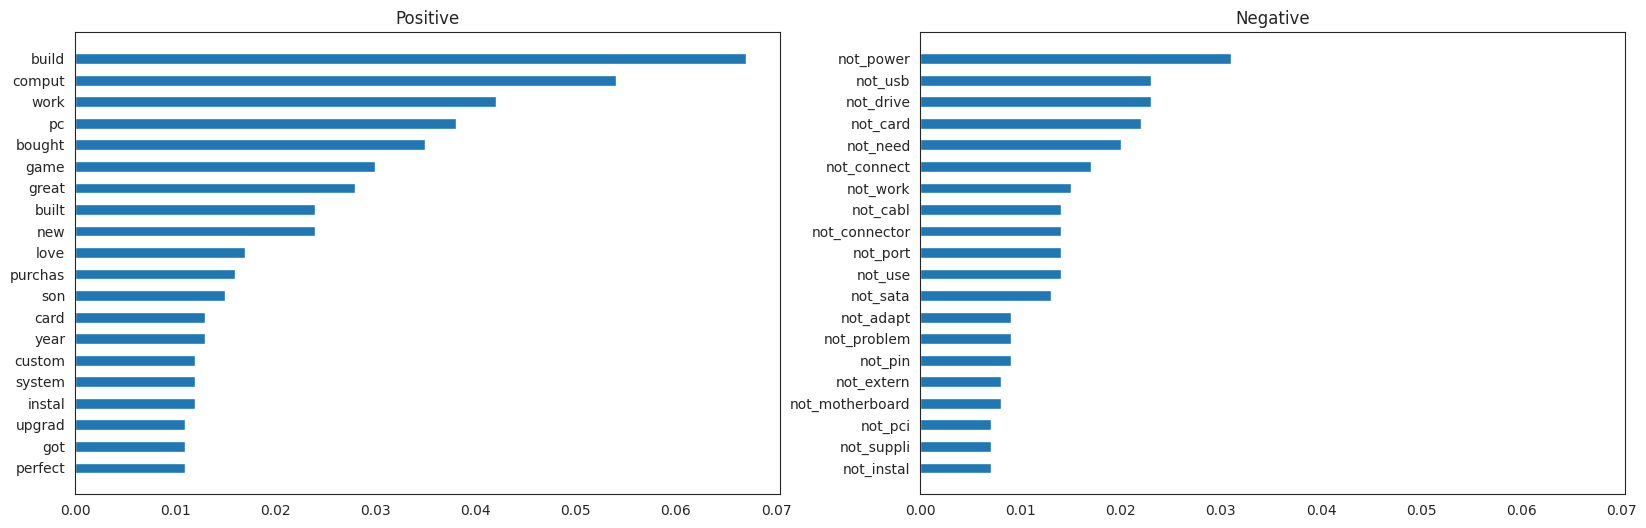

In [155]:
def show_topic(topic, n=20):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)
    axes = axes.flatten()

    for s in range(2):
        words = prob_words_df[f"S{s}-{topic}"][:n]
        weights = list(map(list, zip(*words.map(get_word_weight))))

        weights = pd.DataFrame({"names": weights[0], "weights": weights[1]})
        weights.sort_values("weights", inplace=True)

        axes[s].barh(weights["names"], weights["weights"], height=0.5)
        axes[s].set_title("Positive" if s == 0 else "Negative")


def print_examples(topic, k=5, show_tokens=True):
    ddf = reviews_df.copy()
    ddf["topics"] = ddf["topics"].apply(lambda x: set([y["colname"] for y in x]))

    pos_examples = pd.Series(
        [row["tokens" if show_tokens else "text"] for i, row in ddf.iterrows() if f"S0-{topic}" in row["topics"]]
    ).sample(k)
    neg_examples = pd.Series(
        [row["tokens" if show_tokens else "text"] for i, row in ddf.iterrows() if f"S1-{topic}" in row["topics"]]
    ).sample(k)

    print(
        "Positive ---------------------------------------------------------------------------------\n"
    )
    [print(">----------\n", ex) for ex in pos_examples]

    print(
        "\nNegative ---------------------------------------------------------------------------------"
    )
    [print(">----------\n", ex) for ex in neg_examples]


topic_mapping = {
    "T0": "Power Supply",
    "T1": "Time",
    "T2": "Delivery",
    "T3": "Cooling System",
    "T4": "Cooling System",
    "T5": "Performance",
    "T6": "Memory",
    "T7": "Satisfaction",
    "T8": "Power Supply",
    "T9": "Price",
    "T10": "PC",
    "T11": "Video",
    "T12": "Performance",
    "T13": "Installation",
    "T14": "Satisfaction",
    "T15": "Cooling System",
    "T16": "Temperature",
    "T17": "Overclocking",
    "T18": "Satisfaction",
    "T19": "Installation",
    "T20": "Satisfaction",
    "T21": "Satisfaction",
    "T22": "Sound",
    "T23": "Power Supply",
    "T24": "Installation",
    "T25": "Quality",
    "T26": "Quality",
    "T27": "Delivery",
    "T28": "Aesthetic",
    "T29": "Performance",
    "T30": "Installation",
    "T31": "PC Build",
    "T32": "Installation",
    "T33": "Processor",
    "T34": "Upgrade",
    "T35": "Satisfaction",
    "T36": "Motherboard",
    "T37": "Satisfaction",
    "T38": "Cooling System",
    "T39": "Installation",
    "T40": "Performance", # gaming
    "T41": "Motherboard",
    "T42": "Cooling System",
    "T43": "Optical Disc",
    "T44": "Memory",
    "T45": "Thermal Paste",
    "T46": "Satisfaction",
    "T47": "Satisfaction",
    "T48": "Motherboard",
    "T49": "Memory"
}

topic = "T31"
show_topic(topic, n=20)

In [156]:
print_examples(topic, show_tokens=True)

Positive ---------------------------------------------------------------------------------

>----------
 [['bought', 'build', 'comput'], ['fit', 'suppos', 'not_problem', 'not_far']]
>----------
 [['replac', 'fail', 'power', 'suppli', 'system', 'not_physic', 'not_fit', 'not_power', 'not_suppli', 'not_longer', 'allow', 'power', 'suppli', 'fan'], ['fit', 'perfect', 'work', 'fine', 'number', 'month']]
>----------
 [['need', 'comput'], ['work', 'flawless', 'great', 'price']]
>----------
 [['great', 'ram', 'desktop', 'budget']]
>----------
 [['perfect'], ['run', 'game', 'highest', 'set'], ['love']]

Negative ---------------------------------------------------------------------------------
>----------
 [['buy', 'watt', 'version', 'older', 'machin', 'replac', 'year', 'old', 'psu', 'die', 'moment'], ['not_fail', 'not_need', 'not_ground', 'not_wire', 'not_switch', 'not_jumper', 'not_turbo', 'not_display', 'not_love']]
>----------
 [['doubl', 'current', 'ram', 'addit'], ['not_sure', 'not_differ',

In [157]:
phi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Phi.csv")
words_probs = phi_df.set_index("Unnamed: 0")
tot_probs = words_probs.sum(axis=1)

pos_t = [f"S0-T{t}" for t in range(n_topics)]
pos_probs = words_probs[pos_t]
pos_max_probs = pos_probs.sum(axis=1).max()

neg_t = [f"S1-T{t}" for t in range(n_topics)]
neg_probs = words_probs[neg_t]
neg_max_probs = neg_probs.sum(axis=1).max()

print(pos_max_probs, neg_max_probs)


#pos_probs.sum(axis=1) / pos_max_probs
probs = pd.DataFrame({
    "pos": pos_probs.sum(axis=1) / tot_probs,
    "neg": neg_probs.sum(axis=1) / tot_probs
})


1.9340590061931133 1.1813846392504488


## Corsair Data

In [158]:
corsair_df = reviews_df[reviews_df["brand"] == "corsair"].copy()

from_year = 2018
to_year = 2018

from_year = pd.Timestamp(year=from_year, month=1, day=1)
to_year = pd.Timestamp(year=to_year, month=12, day=31)

year_mask = (corsair_df["timestamp"] >= from_year) & (corsair_df["timestamp"] <= to_year)
corsair_df_2018 = corsair_df[year_mask].copy()

## Sentiment

In [159]:
doc_sentiment = pi_df.idxmax(axis=1).map(lambda x: "positive" if x == 0 else "negative")
reviews_df["sentiment"] = doc_sentiment

In [160]:
fig = px.pie(
    corsair_df_2018["sentiment"].value_counts(),
    values="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    names=["positive", "negative"],
    hole=0.65,
    width=400,
    height=400,
)
fig.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
        "font_color": "#000000",
    }
)

# cambiare colori editor per salvare il grafico
fig.write_image("../output/sentiment.png")
fig

KeyError: 'sentiment'

### Sentiment Over Time

In [ ]:
from dashboard.utils import default_layout

corsair_df = reviews_df[reviews_df["brand"] == "corsair"].copy()

period = "Y"
corsair_df["period"] = corsair_df["timestamp"].dt.to_period(period)
corsair_df["period"] = corsair_df["period"].dt.to_timestamp()

sentiments_count = corsair_df.groupby("period")["sentiment"].value_counts()
sentiments_df = pd.DataFrame(sentiments_count).rename(columns={"sentiment": "count"}).reset_index()
total_reviews = sentiments_df.groupby("period")["count"].sum().reset_index()

sentiments_df = pd.merge(sentiments_df, total_reviews, on="period")
sentiments_df["percentage"] = sentiments_df["count_x"] / sentiments_df["count_y"] * 100

fig = px.bar(
    sentiments_df,
    x="period",
    y="percentage",
    color="sentiment",
    #markers=True,
    category_orders={"sentiment": ["positive", "negative"]},
    color_discrete_sequence=["#27d957", "#f54242"],
    width=1000,
    height=400,
)

fig.update_layout(default_layout)
fig.update_layout(legend_orientation="v", margin=dict(t=40))
fig.update_yaxes(title_text="% Reviews", ticksuffix="%")
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
        "font_color": "#000000",
    }
)

fig.write_image("../output/sentiment_over_time.png")
fig

### Sentiment Categories

In [ ]:
sentiments_count = corsair_df_2018.groupby("category")["sentiment"].value_counts()
sentiments_count_perc = sentiments_count / sentiments_count.groupby("category").sum() * 100
sentiments_df_perc = pd.DataFrame(sentiments_count_perc).rename(columns={"sentiment": "percentage"}).reset_index()
sentiments_df_perc.sort_values(by="percentage", inplace=True)
print(sentiments_df_perc)

category_orders = {"sentiment": ["positive", "negative"]}

fig = px.bar(
    sentiments_df_perc,
    x="percentage",
    y="category",
    color="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    barmode="relative",
    category_orders=category_orders,
    width=800,
    height=400,
)

fig.update_xaxes(ticksuffix="%")
fig.update_layout(default_layout)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), showlegend=False)
fig.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
        "font_color": "#000000",
    }
)
fig.write_image("../output/sentiment_categories.png")
fig

## Topics

In [ ]:
count = Counter()
for x in corsair_df["topics"].values:
    topics = set([topic_mapping[f"T{y['topic']}"] for y in x])
    count.update(topics)

topics_count = pd.DataFrame(count.items(), columns=["topic", "count"])
topics_count["topic"] = topics_count["topic"].astype("category")
# topics_count["topic"] = (
#     topics_count["topic"].apply(lambda x: topic_mapping[x]).astype("category")
# )
topics_count = pd.DataFrame(topics_count.groupby("topic")["count"].sum()).reset_index()

set1 = {"Satisfaction", "Price", "Quality", "Performance", "Delivery", "Power Supply", "Memory", "Cooling System", "Installation", "Aesthetic", "Overclocking"}
topics_count = topics_count[topics_count["topic"].isin(set1)].copy()

topics_count["count"] = (topics_count["count"] / sum(topics_count["count"]) * 100).astype("int")

order = topics_count.sort_values(by="count", ascending=False)
order = order.reset_index()["topic"]

fig1 = px.bar(
    topics_count,
    y="topic",
    x="count",
    color_discrete_sequence=[secondary_color],
    category_orders=dict(topic=order),
    width=1000,
    height=600,
)
fig1.update_xaxes(showgrid=False, title_text="", ticksuffix="%")
fig1.update_yaxes(showgrid=False, title_text="")
fig1.update_layout({"margin": dict(l=0, t=0, r=0, b=0)})

fig1.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
        "font_color": "#000000",
    }
)

# cambiare colori editor per salvare il grafico
fig1.write_image("../output/topics.png")

print(len(topics_count))
fig1

In [ ]:
pos_count = Counter()
neg_count = Counter()

for t in corsair_df["topics"].values:
    pos_topics = set([f"T{s['topic']}" for s in t if s["sentiment"] == 0])
    neg_topics = set([f"T{s['topic']}" for s in t if s["sentiment"] == 1])

    pos_count.update(pos_topics)
    neg_count.update(neg_topics)

pos_df = pd.DataFrame(pos_count.items(), columns=["topic", "positive"])
neg_df = pd.DataFrame(neg_count.items(), columns=["topic", "negative"])

pos_df["topic"] = pos_df["topic"].apply(lambda x: topic_mapping[x]).astype("category")
pos_df = pd.DataFrame(pos_df.groupby("topic")["positive"].sum()).reset_index()

neg_df["topic"] = neg_df["topic"].apply(lambda x: topic_mapping[x]).astype("category")
neg_df = pd.DataFrame(neg_df.groupby("topic")["negative"].sum()).reset_index()

st_counts = pd.merge(pos_df, neg_df, on="topic")
st_counts["topic"] = st_counts["topic"].astype("category")

total = st_counts["positive"] + st_counts["negative"]
st_counts["positive"] = st_counts["positive"] / total * 100
st_counts["negative"] = st_counts["negative"] / total * 100

st_counts.set_index("topic", inplace=True)
st_counts.sort_index(inplace=True)

df_senti = (
    st_counts.stack(level=0)
    .reset_index()
    .rename(columns={"level_1": "sentiment", 0: "count"})
)

df_senti = df_senti[df_senti["topic"].isin(set1)].copy()

topic_order = df_senti.sort_values(["sentiment", "count"], ascending=True)["topic"].unique()

fig2 = px.bar(
    df_senti,
    y="topic",
    x="count",
    color="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    barmode="relative",
    width=1000,
    height=600,
    category_orders=dict(topic=topic_order, sentiment=["pos", "neg"]),
)

fig2.update_xaxes(showgrid=False, title_text="", ticksuffix="%")
fig2.update_yaxes(showgrid=False, title_text="")
fig2.update_layout({"margin": dict(l=0, t=0, r=0, b=0)})

fig2.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
        "font_color": "#000000",
    }
)

# cambiare colori editor per salvare il grafico
fig2.write_image("../output/topics_sentiment.png")
fig2

           brand sentiment      count
6         noctua  positive  93.506494
2  cooler master  positive  84.507042
0         arctic  positive  84.375000
4        corsair  positive  81.111111


/tmp/ipykernel_30354/800561952.py:59: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



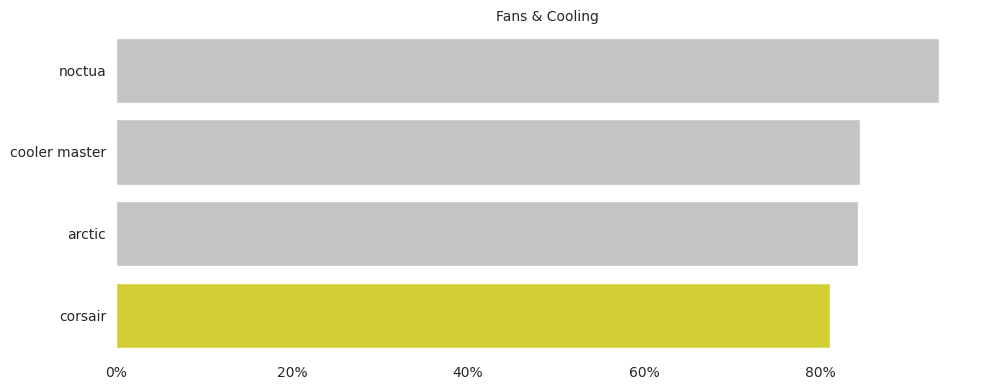

In [161]:
import numpy as np
from matplotlib.ticker import FuncFormatter

def show_values(axs, orient="v", space=.01):
    def _single(ax, color):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center")
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}%'.format(p.get_width())
                ax.text(_x, _y, value, ha="left", color=color, fontsize=14)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax, primary_color if ax['brand'] == 'corsair' else secondary_color)
    else:
        _single(axs, 'black')



CATEGORY =  'Fans & Cooling'
#'Fans & Cooling'
#'Memory'
#'Power Supplies'
#'TV Tuner & Capture Cards'

data_df = pd.read_json(asum_output_dir / "reviews_sentiments.json.gz")
data_df = data_df[
    data_df["brand"].isin(list(data_df["brand"].value_counts()[:100].index))
]

from_year = '2018'
to_year = '2018'
if int(from_year) >= int(to_year):
    to = int(from_year)
else:
    to = int(to_year)

to = pd.Timestamp(year=to, month=12, day=31)

year_mask = (data_df["timestamp"] >= from_year) & (data_df["timestamp"] <= to)



category_df = data_df[data_df["category"] == CATEGORY]
category_df = category_df[category_df["brand"] != "corsair"]

# competitors
competitors = list(category_df["brand"].value_counts().index)[:3] + ["corsair"]
competitors_df = data_df[data_df["brand"].isin(competitors)]


competitors_df = competitors_df[year_mask]

# global sentiment
sentiment_df = competitors_df.groupby("brand")["sentiment"].value_counts()
sentiment_df_perc = sentiment_df / sentiment_df.groupby("brand").sum()
sentiment_df_perc = (
    pd.DataFrame(sentiment_df_perc * 100)
    .rename(columns={"sentiment": "count"})
    .reset_index()
)
sentiment_df_perc = sentiment_df_perc[sentiment_df_perc['sentiment'] == 'positive']
sentiment_df_perc = sentiment_df_perc.sort_values(by='count', ascending=False)

primary_color = "#ECE81A"
secondary_color = "#C3C5C5"
colors = []
for i, row in sentiment_df_perc.iterrows():
    if row['brand'] == 'corsair':
        colors.append(primary_color)
    else:
        colors.append(secondary_color)

fig = plt.figure(figsize=(10, 4))
plot = sns.barplot(
    sentiment_df_perc,
    x="count",
    y="brand",
    palette=colors
)
print(sentiment_df_perc)

#show_values(plot, "h", space=1)

plot.set_title(f'{CATEGORY}', fontsize=10)
plot.set_xlabel('')
plot.set_ylabel('')
plot.xaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}%"))
sns.despine(bottom = True, left = True)
fig.tight_layout()
#plt.savefig(f'../output/competitors_{CATEGORY}.png')

In [ ]:
# positive sentiment in time
competitors_df["period"] = competitors_df["timestamp"].copy().dt.to_period(period)
competitors_df["period"] = competitors_df["period"].dt.to_timestamp()

sentiments_count = competitors_df.groupby(["period", "brand"])["sentiment"].value_counts()
sentiments_df = pd.DataFrame(sentiments_count).rename(columns={"sentiment": "count"}).reset_index()
total_reviews = sentiments_df.groupby(["period", "brand"])["count"].sum().reset_index()

# sentiments_df = pd.merge(sentiments_df, total_reviews, on=["period", "brand"])
# sentiments_df["percentage"] = sentiments_df["count_x"] / sentiments_df["count_y"] * 100

plotly_colors = [secondary_color, "#8c8c8b", "#737372", primary_color]
fig3 = px.line(
    sentiments_df[sentiments_df['sentiment'] == 'positive'],
    x="period",
    y="count",
    height=400,
    width=1000,
    color="brand",
    markers=True,
    category_orders=dict(brand=competitors),
    color_discrete_sequence=plotly_colors,
    title="Positive Sentiment Over Time By Brand",
)
fig3.update_xaxes(showgrid=False, title_text="")
fig3.update_yaxes(showgrid=False, title_text="# Reviews")  # , ticksuffix="%")
fig3.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
        "font_color": "#000000",
    }
)

# cambiare colori editor per salvare il grafico
fig3.write_image("../output/pos_sentiment_competitors.png")
fig3

In [ ]:
from dashboard.pages.comparison.panels.topic_comparison import sentiment_aspect_df, topic_comparison

topics = list(set(sentiment_aspect_df(competitors_df)["topic"].unique()))
figures = []
for i, competitor in enumerate(competitors):
    figures.append(topic_comparison(competitors_df, competitor, plotly_colors[i], topics, 'positive'))
figures[2]

In [ ]:
data_df = pd.read_json(asum_output_dir / "reviews_sentiments.json.gz")
data_df = data_df[
    data_df["brand"].isin(list(data_df["brand"].value_counts()[:100].index))
]

category_df = data_df[data_df["category"] == "Memory"]
category_df = category_df[category_df["brand"] != "corsair"]

# competitors
competitors = list(category_df["brand"].value_counts().index)[:4] + ["corsair"]

competitors_df = data_df[data_df["brand"].isin(competitors)]

# positive sentiment in time
sentiments_count = (
    competitors_df[competitors_df["sentiment"] == "positive"]
    .groupby(["timestamp", "brand"])["sentiment"]
    .value_counts()
)
sentiments_df = (
    pd.DataFrame(sentiments_count).rename(columns={"sentiment": "count"}).reset_index()
)

fig3 = px.line(
    sentiments_df,
    x="timestamp",
    y="count",
    color="brand",
    # title="Sentiment Over Time",
)
fig3.update_xaxes(
    showgrid=False,
    title_text="",
    # range=list(map(lambda x: datetime.datetime(x, 1, 1), years)),
)
fig3.update_yaxes(showgrid=False, title_text="# Reviews")
fig3.update_layout({"margin": dict(l=0, r=0, b=0)})
fig3

In [ ]:
data_df = pd.read_json(asum_output_dir / "reviews_sentiments.json.gz")
data_df = data_df[
    data_df["brand"].isin(list(data_df["brand"].value_counts()[:100].index))
]

category_df = data_df[data_df["category"] == "Memory"]
category_df = category_df[category_df["brand"] != "corsair"]

# competitors
competitors = list(category_df["brand"].value_counts().index)[:5] + ["corsair"]

competitors_df = data_df[data_df["brand"].isin(competitors)]

# negative sentiment in time
sentiments_count = (
    competitors_df[competitors_df["sentiment"] == "negative"]
    .groupby(["timestamp", "brand"])["sentiment"]
    .value_counts()
)
sentiments_df = (
    pd.DataFrame(sentiments_count).rename(columns={"sentiment": "count"}).reset_index()
)

fig4 = px.line(
    sentiments_df,
    x="timestamp",
    y="count",
    color="brand",
    # title="Sentiment Over Time",
)
fig4.update_xaxes(
    showgrid=False,
    title_text="",
    # range=list(map(lambda x: datetime.datetime(x, 1, 1), years)),
)
fig4.update_yaxes(showgrid=False, title_text="# Reviews")
fig4.update_layout({"margin": dict(l=0, r=0, b=0)})
fig4

In [ ]:
reviews_df["topics"]

In [ ]:
def map_topics(x):
    [y.update({"name": topic_mapping[f"T{y['topic']}"]}) for y in x]
    return x


map_topics(reviews_df["topics"][0])

In [ ]:
reviews_df["topics"] = reviews_df["topics"].apply(map_topics)

In [ ]:
reviews_df["topics"]

In [ ]:
reviews_df.to_json(asum_output_dir / "reviews_sentiments.json.gz", orient="records")

# ASPECT BASED SENTIMENT ANALYSIS (JST)

In [ ]:
NORM = "stemming"
FIELD = "text"

n_runs = 10
n_topics = 50
iterations = 1000

alpha = -1
beta = -1
gamma = -1

# Read Reviews Data

In [ ]:
# load tokens
reviews_df = pd.read_json(processed_data_dir / f"reviews_{FIELD}_{NORM}.json.gz")

too_long = reviews_df["tokens"].apply(
    lambda x: any([len(sent) > 50 for sent in x])
)  # len(list(chain.from_iterable(x))) > 50
empty = reviews_df["tokens"].apply(lambda x: len(list(chain.from_iterable(x))) == 0)

print(f"Too Long Reviews: {too_long.sum() / len(reviews_df) * 100:.2f}%")
print(f"Empty Reviews: {empty.sum() / len(reviews_df) * 100:.2f}%")

reviews_df["tokens"] = reviews_df["tokens"].apply(
    lambda x: [sent for sent in x if len(sent) <= 50]
)

In [ ]:
# columns name
columns_name = []

for x in range(2):
    for y in range(n_topics):
        columns_name.append("S" + str(x) + "-T" + str(y))

## PHI = vocabulary x senti aspects

In [ ]:
# prepare phi file for analysis
with open(out_dir / "jst" / "final.phi") as f:
    lines = f.readlines()

    phi = {}
    tmp = ""
    for i, line in enumerate(lines):
        if i % 2 != 0:
            phi[tmp] = [float(x.strip()) for x in line.split(" ") if x.strip() != ""]
        else:
            tmp = line.strip()

phi_df = pd.DataFrame(phi)
phi_df.columns = columns_name
phi_df

## PI = documents x sentiment

In [ ]:
# prepare pi file for analysis
pi_df = pd.read_csv(out_dir / "jst" / "final.pi", sep=" ", header=None)
pi_df.drop([0, 1, 4], axis=1, inplace=True)
pi_df.columns = ["S0", "S1"]
pi_df

## THETA = documents x senti aspects

In [ ]:
with open(out_dir / "jst" / "final.theta") as f:
    lines = f.readlines()

    theta = []
    tmp = []
    for i, line in enumerate(lines):
        if i % 3 != 0:
            values = [float(x.strip()) for x in line.split(" ") if x.strip() != ""]
            tmp.extend(values)
        else:
            if tmp:
                theta.append(tmp)
                tmp = []

theta_df = pd.DataFrame(theta, columns=columns_name)
theta_df

In [ ]:
f_theta_df = theta_df[theta_df.min(axis=1) != theta_df.max(axis=1)]
print("Reviews without topics: ", len(theta_df) - len(f_theta_df))

T = 0.15

In [ ]:
topics = (theta_df > T).apply(lambda x: list(theta_df.columns[x]), axis=1)
topics

In [ ]:
(f_theta_df > T).sum(axis=1).describe()

In [ ]:
reviews_df["topics"] = topics.apply(lambda x: list(map(map_topic_sentiment, x)))
reviews_df["topics"]

In [ ]:
for x in reviews_df["topics"]:
    if type(x) is float:
        print(x)

## Sentiment

In [ ]:
doc_sentiment = pi_df.idxmax(axis=1).map(
    lambda x: "positive" if x == "S0" else "negative"
)
reviews_df["sentiment"] = doc_sentiment

px.pie(
    reviews_df["sentiment"].value_counts(),
    values="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    names=["positive", "negative"],
    hole=0.65,
)

# Sentiment Over Time

In [ ]:
period = "M"
reviews_df[period] = reviews_df["timestamp"].dt.to_period(period)
reviews_df[period] = reviews_df[period].dt.to_timestamp()

sentiments_count = reviews_df.groupby(period)["sentiment"].value_counts()
sentiments_df = (
    pd.DataFrame(sentiments_count).rename(columns={"sentiment": "count"}).reset_index()
)

fig = px.line(
    sentiments_df,
    x=period,
    y="count",
    color="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    title="Sentiment Over Time",
)
fig.update_xaxes(
    showgrid=False,
    title_text="",
    range=list(map(lambda x: datetime.datetime(x, 1, 1), [1999, 2018])),
)
fig.update_yaxes(showgrid=False, title_text="# Reviews")
fig.update_layout(margin=dict(l=0, r=0, b=0))

## Topics

In [ ]:
count = Counter()
for x in reviews_df["topics"].values:
    if type(x) is float:
        print(x)
        continue
    topics = set(["T" + str(y["topic"]) for y in x])
    count.update(topics)

topics_count = pd.DataFrame(count.items(), columns=["topic", "count"])
# topics_count["topic"] = topics_count["topic"].apply(lambda x: topic_mapping[x]).astype("category")
topics_count = pd.DataFrame(topics_count.groupby("topic")["count"].sum()).reset_index()

order = topics_count.sort_values(by="count", ascending=False)
order = order.reset_index()["topic"]

fig1 = px.bar(
    topics_count,
    y="topic",
    x="count",
    color_discrete_sequence=["#108de4"],
    category_orders=dict(topic=order),
    height=1000,
    width=1200,
)
fig1.update_xaxes(showgrid=False, title_text="")
fig1.update_yaxes(showgrid=False, title_text="")
fig1.update_layout({"margin": dict(l=0, t=0, r=0, b=0)})
fig1

In [ ]:
pos_count = Counter()
neg_count = Counter()

for t in reviews_df["topics"].values:
    if type(t) is float:
        print(t)
        continue

    pos_topics = set([f"T{s['topic']}" for s in t if s["sentiment"] == 0])
    neg_topics = set([f"T{s['topic']}" for s in t if s["sentiment"] == 1])

    pos_count.update(pos_topics)
    neg_count.update(neg_topics)

pos_df = pd.DataFrame(pos_count.items(), columns=["topic", "pos"])
neg_df = pd.DataFrame(neg_count.items(), columns=["topic", "neg"])

# pos_df["topic"] = pos_df["topic"].apply(lambda x: topic_mapping[x]).astype("category")
pos_df = pd.DataFrame(pos_df.groupby("topic")["pos"].sum()).reset_index()

# neg_df["topic"] = neg_df["topic"].apply(lambda x: topic_mapping[x]).astype("category")
neg_df = pd.DataFrame(neg_df.groupby("topic")["neg"].sum()).reset_index()

st_counts = pd.merge(pos_df, neg_df, on="topic")
st_counts["topic"] = st_counts["topic"].astype("category")

total = st_counts["pos"] + st_counts["neg"]
st_counts["pos"] = st_counts["pos"] / total * 100
st_counts["neg"] = st_counts["neg"] / total * 100

st_counts.set_index("topic", inplace=True)
st_counts.sort_index(inplace=True)

df_senti = (
    st_counts.stack(level=0)
    .reset_index()
    .rename(columns={"level_1": "sentiment", 0: "count"})
)

fig2 = px.bar(
    df_senti,
    y="topic",
    x="count",
    color="sentiment",
    color_discrete_sequence=["#f54242", "#27d957"],
    barmode="relative",
    category_orders=dict(topic=order),
)

fig2.update_xaxes(showgrid=False, title_text="")
fig2.update_yaxes(showgrid=False, title_text="")
fig2.update_layout({"margin": dict(l=0, t=0, r=0, b=0)})